# Mini Project: Learn Backtrader  Through 1 Strategy
### 🧠 Backtest a simple RSI/EMA strategy over AAPL for 1 year and log the portfolio change.

🎯 Goal: Understand how to backtest a simple strategy (like RSI + EMA)

| **Concept**             | **How to Approach**                                        |
| ----------------------- | ---------------------------------------------------------- |
| ✅ Cerebro engine        | Learn how to instantiate, add data and strategy            |
| ✅ Strategy class        | Understand __init__() and next()                           |
| ✅ Indicators            | Use built-in ones first (RSI, EMA, SMA)                    |
| ✅ Buy/sell logic        | Focus on basic logic: “if RSI < 30 and close > EMA: buy()” |
| ✅ Plot and broker value | Track before/after cash and plot trades                    |

In [1]:
import backtrader as bt
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

**Create Strategy Class**

In [ ]:
class RsiEmaStrategy(bt.Strategy):
    params = (
        ("rsi_period", 14),
        ("ema_period", 7),
    )

    def __init__(self):
        self.rsi = bt.indicators.RSI(self.data.close, period=self.params.rsi_period)
        self.ema = bt.indicators.EMA(self.data.close, period=self.params.ema_period)

        # Trade tracking
        self.order = None
        self.buy_price = None
        self.buy_date = None
        self.params.stake = 10

        self.trades = []  # Store completed trades here!


    def next(self):
        # Skip bars until indicators are ready
        if len(self) < self.params.rsi_period + 7:   # 14 for RSI + a few more for safety
            return

        # print(f"Date: {self.data.datetime.date(0)}, Close: {self.data.close[0]}, EMA: {self.ema[0]}, RSI: {self.rsi[0]}")
        if self.position.size == 0:
            if self.rsi[0] < 45 :
                self.buy_price = self.data.close[0]
                self.buy_date = self.data.datetime.date(0)
                self.order = self.buy()
        else:
            if self.rsi[0] > 60 and self.data.close[0] < self.ema[0]:
                sell_price = self.data.close[0]
                sell_date = self.data.datetime.date(0)
                self.order = self.sell()

                # Record trade info
                profit = sell_price - self.buy_price
                self.trades.append({
                    'Buy Date': self.buy_date,
                    'Buy Price': round(self.buy_price, 2),
                    'Sell Date': sell_date,
                    'Sell Price': round(sell_price, 2),
                    'Profit': round(profit, 2) * self.params.stake,
                    'Status': 'Closed'
                })

    def stop(self):
        # At the end, if any position is still open, just report it
        if self.position.size > 0:
            current_price = self.data.close[0]
            current_date = self.data.datetime.date(0)

            unrealized_profit = (current_price - self.buy_price) * self.params.stake

            self.trades.append({
                'Buy Date': self.buy_date,
                'Buy Price': round(self.buy_price, 2),
                'Sell Date': current_date,
                'Sell Price': round(current_price, 2),
                'Profit ($)': round(unrealized_profit, 2),
                'Status': 'Open'
            })

In [3]:
class PandasDataAAPL(bt.feeds.PandasData):
    params = (
        ('datetime', None),           # Let Backtrader auto-detect index as datetime
        ('open', 'Open_AAPL'),         # Tell it where "open" is
        ('high', 'High_AAPL'),         # where "high" is
        ('low', 'Low_AAPL'),           # where "low" is
        ('close', 'Close_AAPL'),       # where "close" is
        ('volume', 'Volume_AAPL'),     # where "volume" is
        ('openinterest', -1),          # not used
    )


**Load AAPL Data (1 Year)**

In [4]:
# Download AAPL historical data from Yahoo Finance
data = yf.download('AAPL', start='2020-01-01', end='2025-04-26')

data.columns = ['_'.join(col) for col in data.columns]

print(data.columns)

# Prepare it for Backtrader
# data_bt = bt.feeds.PandasData(dataname=data)
data_bt = PandasDataAAPL(dataname=data)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Index(['Close_AAPL', 'High_AAPL', 'Low_AAPL', 'Open_AAPL', 'Volume_AAPL'], dtype='object')


**Set Up Cerebro Engine**

In [5]:
# Create Cerebro engine
cerebro = bt.Cerebro()

# Add strategy
cerebro.addstrategy(RsiEmaStrategy)

# Add data
cerebro.adddata(data_bt)

# Set starting cash
cerebro.broker.set_cash(10000)

# Set trade size to 10 shares
cerebro.addsizer(bt.sizers.FixedSize, stake=10)

**Run Backtest and Print Results**

In [6]:
# Starting Portfolio Value
portfolio_value_initial = cerebro.broker.getvalue()
print('Starting Portfolio Value: %.2f' % portfolio_value_initial)

# Run
results = cerebro.run()

# Final Portfolio Value
portfolio_value_final = cerebro.broker.getvalue()
print('Final Portfolio Value: %.2f' % portfolio_value_final)

Starting Portfolio Value: 10000.00
Final Portfolio Value: 10914.72


In [7]:
# Access trades
strat = results[0]  # Get the strategy instance
trade_log = pd.DataFrame(strat.trades)

print("Total Trades:", len(trade_log))
print("Total Profit:", trade_log['Profit'].sum())
print("Average Profit per Trade:", trade_log['Profit'].mean())

# Show the trade report
trade_log

Total Trades: 9
Total Profit: 1199.6000000000001
Average Profit per Trade: 149.95000000000002


,Buy Date,Buy Price,Sell Date,Sell Price,Profit,Status,Profit ($)
0,2020-02-27,66.38,2020-06-11,81.74,153.6,Closed,NaN
1,2020-09-08,110.01,2021-07-27,143.82,338.1,Closed,NaN
2,2021-09-17,143.34,2021-12-03,159.06,157.2,Closed,NaN
3,2022-01-19,163.37,2022-08-19,169.27,59.0,Closed,NaN
4,2022-08-30,156.82,2023-02-17,151.03,-58.0,Closed,NaN
5,2023-08-04,180.42,2023-11-29,188.24,78.2,Closed,NaN
6,2024-01-02,184.53,2024-06-10,192.47,79.4,Closed,NaN
7,2024-08-05,208.57,2024-12-18,247.78,392.1,Closed,NaN
8,2025-01-07,241.94,2025-04-25,209.28,NaN,Open,-326.64


Profit:  9.147151164561128 %


<Axes: title={'center': 'Cumulative Profit Over Time'}, xlabel='Buy Date'>

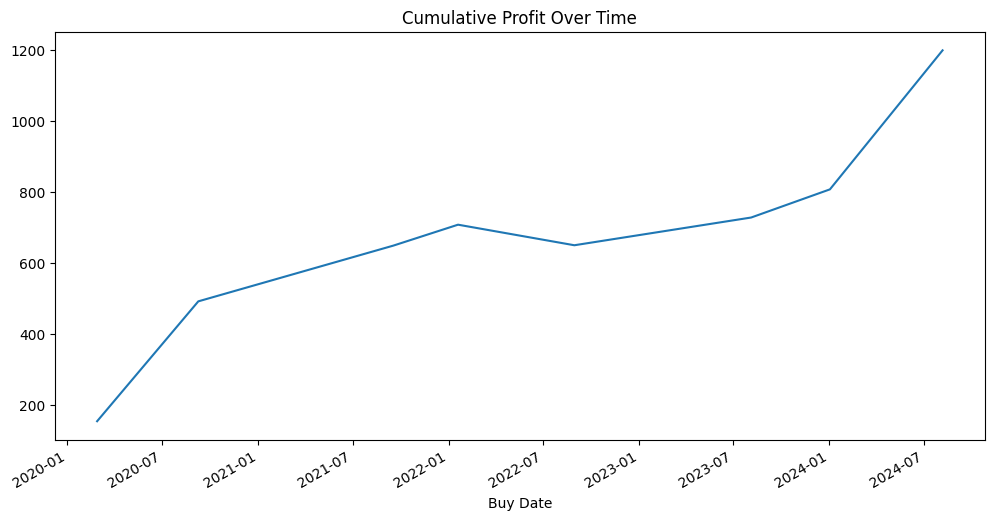

In [10]:
profit_percent = (portfolio_value_final - portfolio_value_initial)/portfolio_value_initial * 100;
print("Profit: ",profit_percent,"%")

# trade_log['Profit'].cumsum().plot(title='Cumulative Profit Over Time')

# Set Buy Date as the index
trade_log.index = pd.to_datetime(trade_log['Buy Date'])

# Now plot
trade_log['Profit'].cumsum().plot(figsize=(12,6), title='Cumulative Profit Over Time')